In [2]:
import pyslha #For interacting with SLHA files
import subprocess #Running command
import scipy #Numeric Library
import sympy #symbolic computation - might not be used here
from scipy import optimize
from sympy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
%matplotlib inline
from numpy import logspace, linspace 
from itertools import product
import glob #filehandling
from subprocess import call
import os
#Path to modified verison of Softsusy 
SoftSUSY_PATH = 'softsusy-4.1.4-Garon/softpoint.x' 
mHiggs = 125 #Higgs Mass for paper
print ("hello")

hello


In [3]:
def slhaPoint(model='FGMCaseB0', mMess=1e12, tanBeta=10, beta2=0, beta3=0, betaeps=0.0, thetavev=0, 
              outputFile='test.slha', Lambda=1e6, mode='point', LambdaGuess=1e6):
    '''
    Code for interacting with SoftSUSY and running the models we've been looking at.
    The models themselves are encoded in a modified version of it. 
    This may seem like extra work because it accepts an arbitrary SLHA2 file, but since our models
    include fitted parameters, like the Yukawa couplings, we need to use the values that it calculates
    during the running. 
    The parameters:
    model - the name of the model in SoftSUSY
    mMess - the messenger scale
    tanBeta - tan beta
    beta2 - beta2
    beta3 - beta3
    outputFile - the name of the file to write to (this step could conceivably be removed by writing the console output to memory)
    Lambda - F/M
    mode - There are 3 modes
        'Fit' - uses Newton's method from a few different starting points
        'Bisect' - uses a Bisection routine from a few different brackets
        'Point' - runs a single point
    LambdaGuess - a guess at the value of Lambda for the 'Fit' mode.
    '''
    
    dataline ="./{} {} --mMess={} --LAMBDA={} --tanBeta={} --beta2={} --beta3={} --thetavev={} --betaeps={} --cgrav=1. > {}"
    startingPoints = [LambdaGuess, 1e6, 5e6, 6e4]
    bracket, l = [(2,5), (5,10), (2,10), (2,8), (4,8), (1,3), (8,12)], 0
    
    #a helper functin that takes a value of x (Lambda), runs it (line 2) and then reads in the Higgs mass
    def f(x):
        string = dataline.format(SoftSUSY_PATH, model, str(mMess), str(x), 
                                 str(tanBeta), str(beta2), str(beta3), str(thetavev), str(betaeps), outputFile)
        subprocess.Popen(string, stdout=None, shell=True).wait()
        #print ("the string is ")
        print (string)
        return pyslha.read(outputFile).blocks['MASS'][25] - mHiggs
    
    if mode == 'Fit':
        #print ('in fit')
        a, i = 0, 0
        while((a <= 0) & (i < len(startingPoints))):
            try:
                #Newton's method
                print ("in try")
                a = optimize.newton(f, startingPoints[i], tol=1e-4)
                print ("in newton")
                print (a)
            except:
                print ('got excepted')
                a = 0
                i += 1
        if (a>0):
            data = pyslha.read(outputFile)
            #accept or reject based on the deviation from the Higgs mass
            if (-0.1 < data.blocks['MASS'][25]-125 < 0.1) :
                try:
                    #if there's something in this location SoftSUSY has an error.
                    data.blocks['SPINFO'][3]
                except:
                    return data
    elif mode == 'Bisect':
        for k in bracket:
            print(k)
            try:
                l = optimize.brentq(f, k[0] * 1e5, k[1] * 1e5, rtol=1e-4)
                if l:
                    break
            except:
                #print('nada')
                continue
        if l:
            data = pyslha.read(outputFile)
            print(data.blocks['MASS'][25])
            if (-0.25 < data.blocks['MASS'][25]-125 < 0.25) :
                try:
                    data.blocks['SPINFO'][3]
                except:
                    return data
            else:
                #the bisection routine tends to get things close but not exact, so it calls 'Fit' if it's close.
                return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit', LambdaGuess=data.blocks['MINPAR'][1])
        else:
            #just to be safe (but is probably unneded)
            return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit')
    else:
        #runs a single point
        try:
            f(Lambda)
            data = pyslha.read(outputFile)
            return data.blocks['MASS'][25], data
        except (pyslha.ParseError, RuntimeError):
            return "No Solution", 0

In [4]:
gridmMess = logspace(6,16,41)
gridLambda = logspace(5,6.,41)

resultsb2mmessVsLambda = {}
for j in product(gridmMess, gridLambda):
    
    
    resultsb2mmessVsLambda[j] = slhaPoint(model='FGMCaseB2', mMess=j[0], Lambda=j[1],mode='Point')
    
    

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=105925.37251772897 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=112201.84543019629 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=118850.22274370189 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=125892.54117941661 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=133352.1432163324 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --be

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=149623.5656094433 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=158489.3192461114 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=167880.4018122559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=177827.94100389228 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=188364.9089489802 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=199526.2314968

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=199526.2314968879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=211348.90398366476 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=223872.11385683378 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=237137.37056616554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=251188.6431509582 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=266072

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=266072.50597988087 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=281838.2931264455 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=298538.26189179573 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=316227.7660168379 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=334965.43915782793 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=354813.38923

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=398107.1705534969 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=421696.5034285823 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=446683.5921509635 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=473151.2589614803 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=501187.2336272725 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thet

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=562341.3251903491 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=595662.1435290109 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=630957.344480193 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=668343.9175686149 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=707945.784

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=707945.7843841374 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=749894.2093324559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=794328.2347242822 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=841395.1416451947 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=891250.9381337459 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776.60168379 --LAMBDA=944060.87628592

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=944060.8762859226 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132.51903491 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=105925.37251772897 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=112201.84543019629 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000.0 --LAMBDA=118850.22274370189 --tanBeta=10 --beta2=0 --beta3=0 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=133352.1432163324 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=141253.75446227554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=149623.5656094433 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=158489.3192461114 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=167880.4018122559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941.00389227 --LAMBDA=177827.9

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=177827.94100389228 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=188364.9089489802 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=199526.2314968879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=211348.90398366476 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=223872.11385683378 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766.01683795 --LAMBDA=237137

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=237137.37056616554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=251188.6431509582 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=266072.50597988087 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=281838.2931264455 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=298538.26189179573 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325.1903491 --LAMBDA=316227.76601

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=316227.7660168379 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=334965.43915782793 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=354813.3892335753 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=375837.4042884443 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=398107.1705534969 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000.0 --LAMBDA=421696.5034285823 --tanBeta=10 --beta2=0 --b

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=421696.5034285823 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=446683.5921509635 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=473151.2589614803 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=501187.2336272725 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410.0389228 --LAMBDA=562341.32

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=562341.3251903491 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=595662.1435290109 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=630957.344480193 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=668343.9175686149 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=707945.7843841374 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660.1683793 --LAMBDA=749894.209

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=749894.2093324559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=794328.2347242822 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=841395.1416451947 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=891250.9381337459 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=944060.8762859226 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251.903491 --LAMBDA=1000000.0 --tan

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=105925.37251772897 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=112201.84543019629 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=118850.22274370189 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=125892.54117941661 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100.38923 --LAMBDA=133352.1432163324 --

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=133352.1432163324 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=141253.75446227554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=149623.5656094433 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=158489.3192461114 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=167880.4018122559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601.683792 --LAMBDA=177827.9

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=177827.94100389228 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=188364.9089489802 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=199526.2314968879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=211348.90398366476 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=223872.11385683378 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519.034904 --LAMBDA=237137

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=237137.37056616554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=251188.6431509582 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=266072.50597988087 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=281838.2931264455 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=298538.26189179573 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000.0 --LAMBDA=316227.7660168379 --tanBeta=10

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=316227.7660168379 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=334965.43915782793 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=354813.3892335753 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=375837.4042884443 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=398107.1705534969 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003.89227 --LAMBDA=421696.5

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=421696.5034285823 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=446683.5921509635 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=473151.2589614803 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=501187.2336272725 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016.83795 --LAMBDA=562341.32

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=595662.1435290109 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=630957.344480193 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=668343.9175686149 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=707945.7843841374 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=749894.2093324559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190.3491 --LAMBDA=794328.234724282

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=794328.2347242822 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=841395.1416451947 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=891250.9381337459 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=944060.8762859226 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000.0 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038.9229 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=105925.37251772897 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=112201.84543019629 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=118850.22274370189 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=125892.54117941661 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168.3794 --LAMBDA=133352.1432163

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=133352.1432163324 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=141253.75446227554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=149623.5656094433 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=158489.3192461114 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=167880.4018122559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903.491 --LAMBDA=177827.9410038

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=177827.94100389228 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=188364.9089489802 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=199526.2314968879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=211348.90398366476 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=223872.11385683378 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000000000.0 --LAMBDA=237137.37056616554

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=237137.37056616554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=251188.6431509582 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=266072.50597988087 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=281838.2931264455 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=298538.26189179573 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794100389.227 --LAMBDA=316227

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=316227.7660168379 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=334965.43915782793 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=354813.3892335753 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=375837.4042884443 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=398107.1705534969 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=31622776601683.793 --LAMBDA=421696.5

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=446683.5921509635 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=473151.2589614803 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=501187.2336272725 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=562341.3251903491 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=56234132519034.91 --LAMBDA=595662.14352901

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=595662.1435290109 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=630957.344480193 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=668343.9175686149 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=707945.7843841374 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=749894.2093324559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=100000000000000.0 --LAMBDA=794328.234724282

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=794328.2347242822 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=841395.1416451947 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=891250.9381337459 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=944060.8762859226 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=177827941003892.28 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=316227766016837.94 --LAMBDA=100000.0 --tanBet

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=100000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=105925.37251772897 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=112201.84543019629 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=118850.22274370189 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=125892.54117941661 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=562341325190349.06 --LAMBDA=133352.1432163

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=133352.1432163324 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=141253.75446227554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=149623.5656094433 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=158489.3192461114 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=167880.4018122559 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000000000000.0 --LAMBDA=177827.9

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=177827.94100389228 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=188364.9089489802 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=199526.2314968879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=211348.90398366476 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=223872.11385683378 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279410038922.8 --LAMBDA=237137

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=237137.37056616554 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=251188.6431509582 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=266072.50597988087 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=281838.2931264455 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=298538.26189179573 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277660168379.5 --LAMBDA=316227

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=316227.7660168379 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=334965.43915782793 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=354813.3892335753 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=375837.4042884443 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=398107.1705534969 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413251903491.0 --LAMBDA=421696.5

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=473151.2589614803 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=501187.2336272725 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=530884.4442309879 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=562341.3251903491 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=595662.1435290109 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1e+16 --LAMBDA=630957.344480193 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1.

Text(0.5, 1.0, 'eps0')

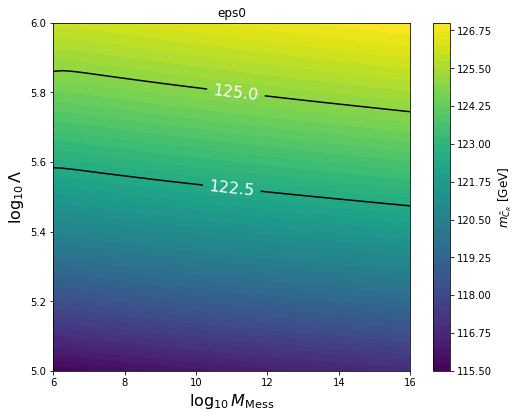

In [5]:
file = resultsb2mmessVsLambda
plotData = []
for i in gridLambda:
    row = []
    for j in gridmMess:
        try:
            row.append(file[(j,i)][0])
        except:
            row.append(0)
    plotData.append(row)
plotData = np.array(plotData)


fig, ax = plt.subplots( figsize=(8, 6.4))

Zm = np.ma.masked_where(plotData < 1.2, plotData)
im = ax.contourf(np.log10(gridmMess), np.log10(gridLambda), Zm,50)

plt.xlabel(r'$\log_{10}\, M_{\rm{Mess}}$',fontsize=16)
plt.ylabel(r'$\log_{10}\,\Lambda$',fontsize=16)
cbar = fig.colorbar(im)
cbar.set_label(r'$m_{\tilde C_{R}}$ [GeV]', size=12)
cs = ax.contour(np.log10(gridmMess), np.log10(gridLambda), Zm, [122.5,125,127.5],colors='k')
ax.clabel(cs, fontsize=16, inline=1, colors='w',fmt="%1.1f")
plt.title("eps0")

In [22]:
plt.savefig('b2mMessVsLambdaEps0')

<Figure size 432x288 with 0 Axes>

In [18]:
print(Zm)

[[115.558688 115.597732 115.638132 ... 116.801636 116.829425 116.857213]
 [115.915506 115.953891 115.993823 ... 117.14894  117.17655  117.204157]
 [116.266132 116.303835 116.343289 ... 117.490003 117.517434 117.544861]
 ...
 [125.721049 125.696413 125.703631 ... 126.584348 126.606365 126.628366]
 [125.906261 125.889379 125.894692 ... 126.768884 126.790789 126.812662]
 [126.023492 126.079567 126.082922 ... 126.950593 126.972376 126.994123]]


In [20]:
p = cs.collections[1].get_paths()[0]

In [21]:
v = p.vertices
x = v[:,0]
y = v[:,1]

In [22]:
x

array([ 6.        ,  6.25      ,  6.5       ,  6.75      ,  7.        ,
        7.25      ,  7.32963946,  7.5       ,  7.75      ,  8.        ,
        8.25      ,  8.5       ,  8.75      ,  9.        ,  9.13967876,
        9.25      ,  9.5       ,  9.75      , 10.        , 10.25      ,
       10.30978224])

In [23]:
y

array([5.86056167, 5.86275443, 5.8611322 , 5.85815523, 5.85472075,
       5.8511462 , 5.85      , 5.8475833 , 5.84405113, 5.84054655,
       5.83707431, 5.83363606, 5.83023233, 5.8268629 , 5.825     ,
       5.82355029, 5.8202991 , 5.81707949, 5.81389029, 5.81073085,
       5.80998205])